
Generated 2500x2500 SPD matrix.
PCG without preconditioner: 1000 iterations, Time: 0.0710s, Error: 1.30e-01
PCG with Jacobi preconditioner: 1000 iterations, Time: 0.0798s, Error: 1.30e-01
PCG with AMG preconditioner: 5 iterations, Time: 0.0090s, Error: 4.83e-04
PCG with MAS preconditioner: 1000 iterations, Time: 0.0618s, Error: 1.30e-01
Direct solver (Cholesky): Time: 0.0092s, Error: 1.62e-13
+----------------------------------------------------------------+
|                   Performance Summary (n=50)                   |
+-----------------------+----------+------------+----------------+
|         Solver        | Time (s) | Iterations | Residual Error |
+-----------------------+----------+------------+----------------+
|   No Preconditioner   |  0.0710  |    1000    |    1.30e-01    |
| Jacobi Preconditioner |  0.0798  |    1000    |    1.30e-01    |
|   AMG Preconditioner  |  0.0090  |     5      |    4.83e-04    |
|   MAS Preconditioner  |  0.0618  |    1000    |    1.30e-01    |


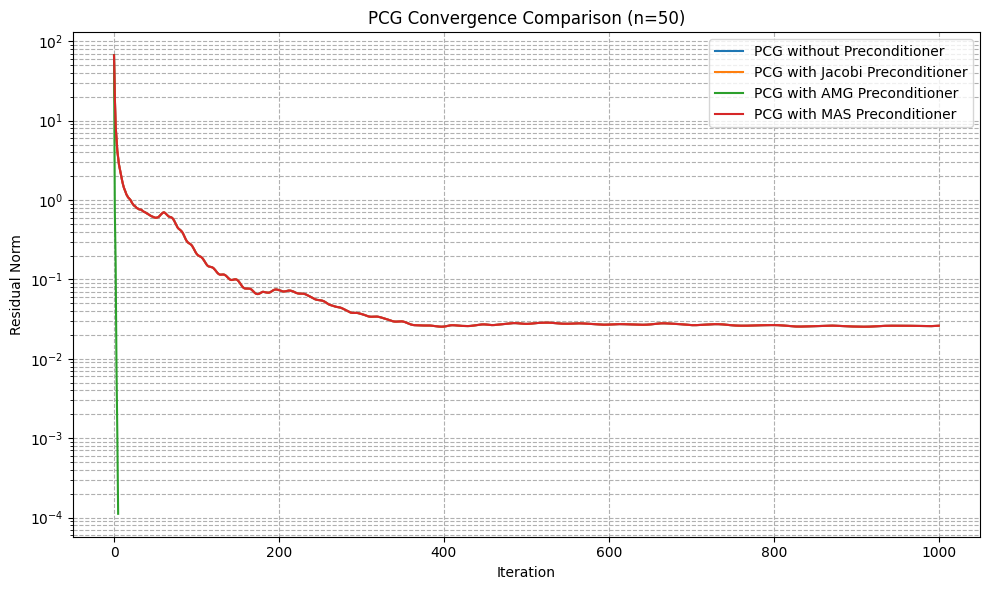


Generated 10000x10000 SPD matrix.
PCG without preconditioner: 1000 iterations, Time: 0.1171s, Error: 5.12e-01
PCG with Jacobi preconditioner: 1000 iterations, Time: 0.1207s, Error: 5.12e-01
PCG with AMG preconditioner: 5 iterations, Time: 0.0133s, Error: 2.00e-03
PCG with MAS preconditioner: 1000 iterations, Time: 0.1273s, Error: 5.12e-01
Direct solver (Cholesky): Time: 0.0452s, Error: 8.35e-13
+----------------------------------------------------------------+
|                  Performance Summary (n=100)                   |
+-----------------------+----------+------------+----------------+
|         Solver        | Time (s) | Iterations | Residual Error |
+-----------------------+----------+------------+----------------+
|   No Preconditioner   |  0.1171  |    1000    |    5.12e-01    |
| Jacobi Preconditioner |  0.1207  |    1000    |    5.12e-01    |
|   AMG Preconditioner  |  0.0133  |     5      |    2.00e-03    |
|   MAS Preconditioner  |  0.1273  |    1000    |    5.12e-01    

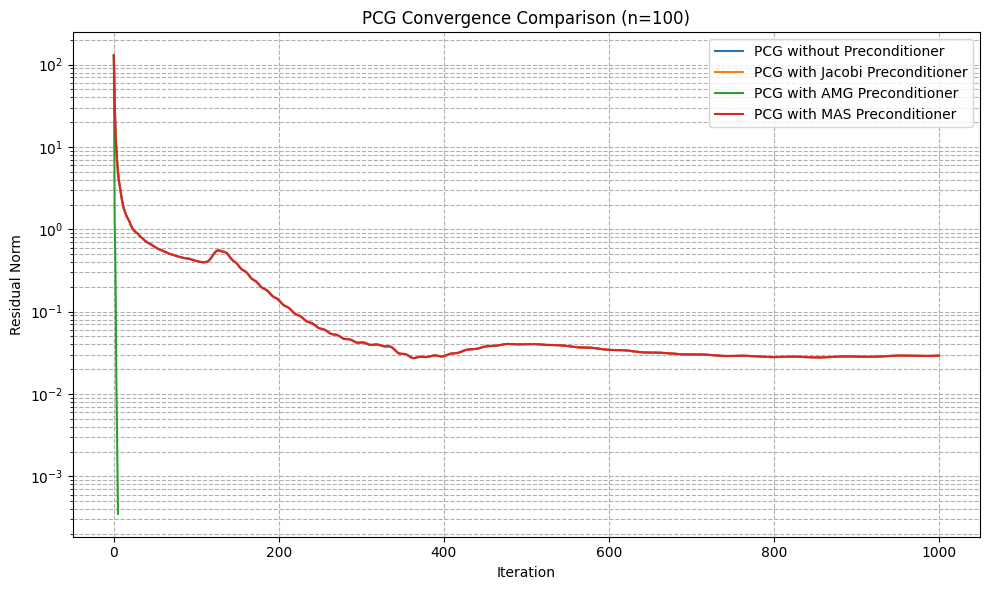


Generated 40000x40000 SPD matrix.
PCG without preconditioner: 1000 iterations, Time: 0.9769s, Error: 1.13e+00
PCG with Jacobi preconditioner: 1000 iterations, Time: 0.8946s, Error: 1.13e+00
PCG with AMG preconditioner: 5 iterations, Time: 0.0398s, Error: 8.94e-03
PCG with MAS preconditioner: 1000 iterations, Time: 0.8546s, Error: 1.13e+00
Direct solver (Cholesky): Time: 0.2153s, Error: 5.49e-12
+----------------------------------------------------------------+
|                  Performance Summary (n=200)                   |
+-----------------------+----------+------------+----------------+
|         Solver        | Time (s) | Iterations | Residual Error |
+-----------------------+----------+------------+----------------+
|   No Preconditioner   |  0.9769  |    1000    |    1.13e+00    |
| Jacobi Preconditioner |  0.8946  |    1000    |    1.13e+00    |
|   AMG Preconditioner  |  0.0398  |     5      |    8.94e-03    |
|   MAS Preconditioner  |  0.8546  |    1000    |    1.13e+00    

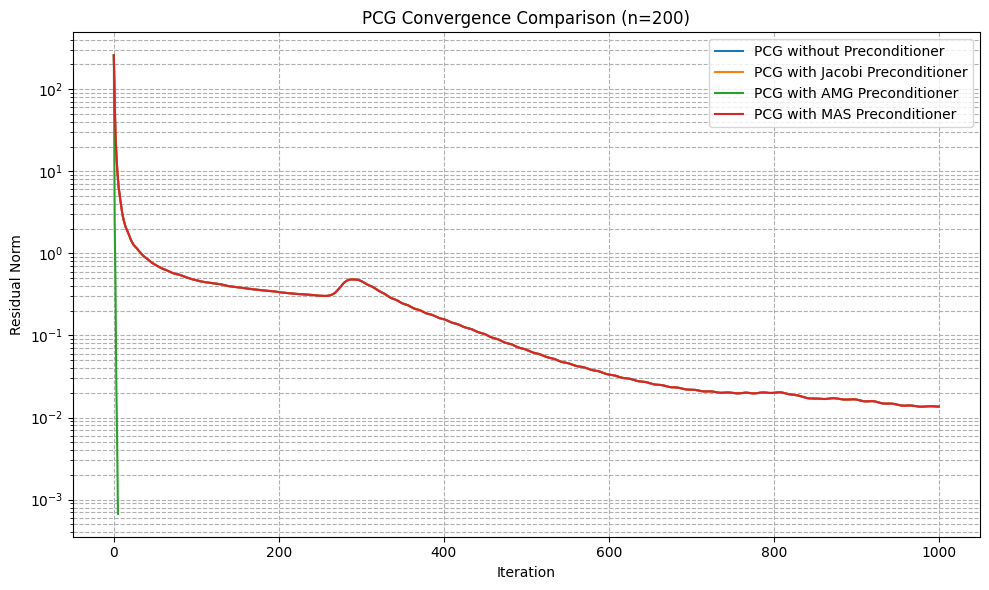


Generated 90000x90000 SPD matrix.
PCG without preconditioner: 1000 iterations, Time: 2.0262s, Error: 2.77e+00
PCG with Jacobi preconditioner: 1000 iterations, Time: 1.8226s, Error: 2.77e+00
PCG with AMG preconditioner: 5 iterations, Time: 0.0772s, Error: 2.45e-03
PCG with MAS preconditioner: 1000 iterations, Time: 2.1286s, Error: 2.77e+00
Direct solver (Cholesky): Time: 0.8183s, Error: 1.53e-11
+----------------------------------------------------------------+
|                  Performance Summary (n=300)                   |
+-----------------------+----------+------------+----------------+
|         Solver        | Time (s) | Iterations | Residual Error |
+-----------------------+----------+------------+----------------+
|   No Preconditioner   |  2.0262  |    1000    |    2.77e+00    |
| Jacobi Preconditioner |  1.8226  |    1000    |    2.77e+00    |
|   AMG Preconditioner  |  0.0772  |     5      |    2.45e-03    |
|   MAS Preconditioner  |  2.1286  |    1000    |    2.77e+00    

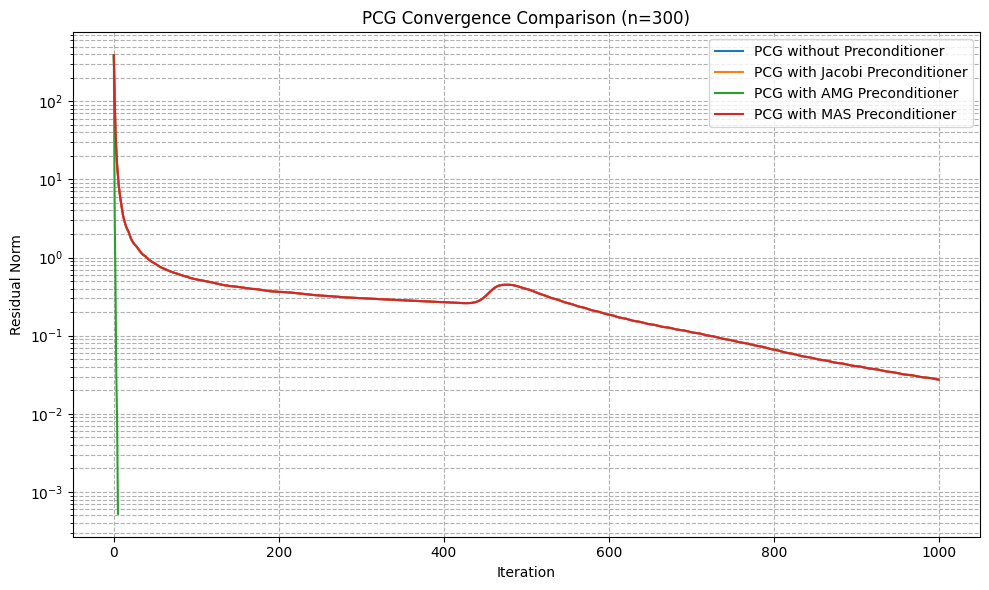

In [2]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import pyamg
import matplotlib.pyplot as plt
import time
from prettytable import PrettyTable
from joblib import Parallel, delayed

def generate_spd_matrix(n):
    """
    Generates a 2D Laplacian matrix of size (n^2 x n^2).
    """
    N = n * n
    diagonals = []
    offsets = []

    # Main diagonal
    diagonals.append(4 * np.ones(N))
    offsets.append(0)

    # Off-diagonals
    diagonals.append(-1 * np.ones(N - 1))
    offsets.append(-1)
    diagonals.append(-1 * np.ones(N - 1))
    offsets.append(1)
    diagonals.append(-1 * np.ones(N - n))
    offsets.append(-n)
    diagonals.append(-1 * np.ones(N - n))
    offsets.append(n)

    A = sp.diags(diagonals, offsets, shape=(N, N), format='csr')

    # Adjust for Dirichlet boundary conditions
    for i in range(n):
        A[i * n, i * n + 1] = 0
        A[i * n + n - 1, i * n + n - 2] = 0

    return A

def partition_with_overlap(A, num_subdomains, overlap=1):
    """
    Partitions the matrix A into subdomains with overlapping regions.
    """
    N = A.shape[0]
    rows_per_sub = N // num_subdomains
    subdomains = []
    subdomain_indices = []
    
    for i in range(num_subdomains):
        start_row = i * rows_per_sub
        end_row = (i + 1) * rows_per_sub if i != num_subdomains - 1 else N
        # Apply overlap
        if i != 0:
            start_row = max(start_row - overlap, 0)
        if i != num_subdomains - 1:
            end_row = min(end_row + overlap, N)
        sub_A = A[start_row:end_row, start_row:end_row].copy()
        subdomains.append(sub_A)
        subdomain_indices.append((start_row, end_row))
    
    return subdomains, subdomain_indices

def build_local_solvers(subdomains):
    """
    Builds local solvers for each subdomain.
    """
    local_solvers = []
    for idx, sub_A in enumerate(subdomains):
        sub_A_csc = sub_A.tocsc()
        try:
            lu = spla.splu(sub_A_csc)
            local_solvers.append(lu)
        except RuntimeError as e:
            print(f"LU factorization failed for subdomain {idx}: {e}")
            local_solvers.append(None)
    return local_solvers

def additive_schwarz_preconditioner(A, num_subdomains, overlap=1):
    """
    Constructs an Additive Schwarz Preconditioner.
    """
    subdomains, subdomain_indices = partition_with_overlap(A, num_subdomains, overlap)
    local_solvers = build_local_solvers(subdomains)

    def M_inv(r):
        results = Parallel(n_jobs=-1)(
            delayed(apply_solver_parallel)(lu, r[start:end])
            for lu, (start, end) in zip(local_solvers, subdomain_indices)
        )
        
        z = np.zeros_like(r)
        for z_sub, (start, end) in zip(results, subdomain_indices):
            z[start:end] += z_sub
        return z
    
    return M_inv

def multilevel_additive_schwarz_preconditioner(A, num_subdomains, overlap=1, levels=2):
    """
    Constructs a Multilevel Additive Schwarz Preconditioner.
    """
    if levels < 1:
        raise ValueError("Number of levels must be at least 1.")
    
    subdomains, subdomain_indices = partition_with_overlap(A, num_subdomains, overlap)
    local_solvers = build_local_solvers(subdomains)
    
    if levels > 1:
        ml = pyamg.ruge_stuben_solver(A)
        if len(ml.levels) < 2:
            raise ValueError("Insufficient levels created by PyAMG for multilevel preconditioning.")
        coarse_A = ml.levels[-1].A
        coarse_M_inv = multilevel_additive_schwarz_preconditioner(coarse_A, num_subdomains, overlap, levels-1)
    else:
        coarse_M_inv = None

def apply_solver_parallel(lu, r_sub):
    """
    Apply local solver to subdomain residual.
    """
    if lu is not None and np.linalg.norm(r_sub) > 1e-12:
        return lu.solve(r_sub)
    return np.zeros_like(r_sub)

def M_inv(r):
    results = Parallel(n_jobs=-1)(
        delayed(lambda lu, r_sub: apply_solver_parallel(lu, r_sub))(lu, r[start:end])
        for lu, (start, end) in zip(local_solvers, subdomain_indices)
    )
    
    z = np.zeros_like(r)
    for z_sub, (start, end) in zip(results, subdomain_indices):
        z[start:end] += z_sub
    return z


def pcg(A, b, M=None, tol=1e-5, max_iter=1000):
    """
    Preconditioned Conjugate Gradient method.
    """
    x = np.zeros_like(b)
    r = b - A.dot(x)
    if M is not None:
        z = M(r)
    else:
        z = r.copy()
    p = z.copy()
    rz_old = np.dot(r, z)
    residual_norm0 = np.linalg.norm(r)
    residuals = [residual_norm0]

    for i in range(max_iter):
        Ap = A.dot(p)
        pAp = np.dot(p, Ap)
        if pAp == 0:
            print("Breakdown: Division by zero.")
            return x, i, residuals
        alpha = rz_old / pAp
        x += alpha * p
        r -= alpha * Ap
        residual_norm = np.linalg.norm(r)
        residuals.append(residual_norm)
        if residual_norm < tol * residual_norm0:
            return x, i + 1, residuals
        if M is not None:
            z = M(r)
        else:
            z = r.copy()
        rz_new = np.dot(r, z)
        beta = rz_new / rz_old
        p = z + beta * p
        rz_old = rz_new

    return x, max_iter, residuals

def jacobi_preconditioner(A):
    """
    Constructs a Jacobi (diagonal) preconditioner.

    Parameters:
    - A: Sparse SPD matrix in CSR format.

    Returns:
    - M_inv: Function to apply the Jacobi preconditioner.
    """
    M_inv = 1.0 / A.diagonal()
    # Handle zeros on the diagonal to avoid division by zero
    M_inv[np.isinf(M_inv)] = 0.0
    def apply_jacobi(r):
        return M_inv * r
    return apply_jacobi

def amg_preconditioner(A):
    """
    Constructs an AMG (Algebraic Multigrid) preconditioner using PyAMG.

    Parameters:
    - A: Sparse SPD matrix in CSR format.

    Returns:
    - M: Function to apply the AMG preconditioner.
    """
    ml = pyamg.ruge_stuben_solver(A)
    return ml.aspreconditioner()

def direct_solve(A, b):
    """
    Solves Ax = b using a direct solver (Cholesky).

    Parameters:
    - A: Sparse SPD matrix in CSR format.
    - b: Right-hand side vector.

    Returns:
    - x: Solution vector.
    """
    x = spla.spsolve(A, b)
    return x

def run_comparisons_with_mas(n=50, tol=1e-5, max_iter=1000, num_subdomains=10, overlap=1, levels=2):
    """
    Runs comparisons between different solvers and preconditioners, including MAS.

    Parameters:
    - n: Grid size for generating the Laplacian matrix (n x n).
    - tol: Tolerance for PCG convergence.
    - max_iter: Maximum number of PCG iterations.
    - num_subdomains: Number of subdomains for ASM/MAS.
    - overlap: Number of rows to overlap between subdomains.
    - levels: Number of levels in MAS.

    Returns:
    - results: Dictionary containing performance metrics.
    - residuals_pcg: Residual norms for PCG without preconditioner.
    - residuals_pcg_jacobi: Residual norms for PCG with Jacobi preconditioner.
    - residuals_pcg_amg: Residual norms for PCG with AMG preconditioner.
    - residuals_pcg_mas: Residual norms for PCG with MAS preconditioner.
    """
    # Generate SPD matrix
    A = generate_spd_matrix(n)
    N = n * n
    print(f"\nGenerated {N}x{N} SPD matrix.")
    
    # Generate random solution and compute corresponding RHS
    np.random.seed(0)  # For reproducibility
    x_true = np.random.rand(N)
    b = A.dot(x_true)
    
    # Initialize preconditioners
    M_jacobi = jacobi_preconditioner(A)
    M_amg = amg_preconditioner(A)
    M_mas = multilevel_additive_schwarz_preconditioner(A, num_subdomains, overlap, levels)
    
    # Initialize results dictionary
    results = {
        'No Preconditioner': {'time': None, 'iterations': None, 'error': None},
        'Jacobi Preconditioner': {'time': None, 'iterations': None, 'error': None},
        'AMG Preconditioner': {'time': None, 'iterations': None, 'error': None},
        'MAS Preconditioner': {'time': None, 'iterations': None, 'error': None},
        'Direct Solver': {'time': None, 'error': None},
    }
    
    # PCG without preconditioner
    start_time = time.time()
    x_pcg, iter_pcg, residuals_pcg = pcg(A, b, M=None, tol=tol, max_iter=max_iter)
    end_time = time.time()
    error_pcg = np.linalg.norm(x_true - x_pcg)
    results['No Preconditioner']['time'] = end_time - start_time
    results['No Preconditioner']['iterations'] = iter_pcg
    results['No Preconditioner']['error'] = error_pcg
    print(f"PCG without preconditioner: {iter_pcg} iterations, Time: {end_time - start_time:.4f}s, Error: {error_pcg:.2e}")
    
    # PCG with Jacobi preconditioner
    start_time = time.time()
    x_pcg_jacobi, iter_pcg_jacobi, residuals_pcg_jacobi = pcg(A, b, M=M_jacobi, tol=tol, max_iter=max_iter)
    end_time = time.time()
    error_pcg_jacobi = np.linalg.norm(x_true - x_pcg_jacobi)
    results['Jacobi Preconditioner']['time'] = end_time - start_time
    results['Jacobi Preconditioner']['iterations'] = iter_pcg_jacobi
    results['Jacobi Preconditioner']['error'] = error_pcg_jacobi
    print(f"PCG with Jacobi preconditioner: {iter_pcg_jacobi} iterations, Time: {end_time - start_time:.4f}s, Error: {error_pcg_jacobi:.2e}")
    
    # PCG with AMG preconditioner
    start_time = time.time()
    x_pcg_amg, iter_pcg_amg, residuals_pcg_amg = pcg(A, b, M=M_amg, tol=tol, max_iter=max_iter)
    end_time = time.time()
    error_pcg_amg = np.linalg.norm(x_true - x_pcg_amg)
    results['AMG Preconditioner']['time'] = end_time - start_time
    results['AMG Preconditioner']['iterations'] = iter_pcg_amg
    results['AMG Preconditioner']['error'] = error_pcg_amg
    print(f"PCG with AMG preconditioner: {iter_pcg_amg} iterations, Time: {end_time - start_time:.4f}s, Error: {error_pcg_amg:.2e}")
    
    # PCG with MAS preconditioner
    start_time = time.time()
    x_pcg_mas, iter_pcg_mas, residuals_pcg_mas = pcg(A, b, M=M_mas, tol=tol, max_iter=max_iter)
    end_time = time.time()
    error_pcg_mas = np.linalg.norm(x_true - x_pcg_mas)
    results['MAS Preconditioner']['time'] = end_time - start_time
    results['MAS Preconditioner']['iterations'] = iter_pcg_mas
    results['MAS Preconditioner']['error'] = error_pcg_mas
    print(f"PCG with MAS preconditioner: {iter_pcg_mas} iterations, Time: {end_time - start_time:.4f}s, Error: {error_pcg_mas:.2e}")
    
    # Direct Solver
    start_time = time.time()
    try:
        x_direct = direct_solve(A, b)
        end_time = time.time()
        error_direct = np.linalg.norm(x_true - x_direct)
        results['Direct Solver']['time'] = end_time - start_time
        results['Direct Solver']['error'] = error_direct
        print(f"Direct solver (Cholesky): Time: {end_time - start_time:.4f}s, Error: {error_direct:.2e}")
    except Exception as e:
        end_time = time.time()
        results['Direct Solver']['time'] = end_time - start_time
        results['Direct Solver']['error'] = str(e)
        print(f"Direct solver (Cholesky) failed: {e}")
    
    return results, residuals_pcg, residuals_pcg_jacobi, residuals_pcg_amg, residuals_pcg_mas

def plot_convergence_extended(residuals_pcg, residuals_pcg_jacobi, residuals_pcg_amg, residuals_pcg_mas, n):
    """
    Plots the convergence of different PCG solvers, including MAS.

    Parameters:
    - residuals_pcg: Residual norms for PCG without preconditioner.
    - residuals_pcg_jacobi: Residual norms for PCG with Jacobi preconditioner.
    - residuals_pcg_amg: Residual norms for PCG with AMG preconditioner.
    - residuals_pcg_mas: Residual norms for PCG with MAS preconditioner.
    - n: Grid size used for generating the matrix (for title purposes).
    """
    plt.figure(figsize=(10, 6))
    plt.semilogy(residuals_pcg, label='PCG without Preconditioner')
    plt.semilogy(residuals_pcg_jacobi, label='PCG with Jacobi Preconditioner')
    plt.semilogy(residuals_pcg_amg, label='PCG with AMG Preconditioner')
    plt.semilogy(residuals_pcg_mas, label='PCG with MAS Preconditioner')
    plt.xlabel('Iteration')
    plt.ylabel('Residual Norm')
    plt.title(f'PCG Convergence Comparison (n={n})')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.tight_layout()
    plt.show()

def display_results_table_extended(results, n):
    """
    Displays the performance results in a table format, including MAS.

    Parameters:
    - results: Dictionary containing performance metrics.
    - n: Grid size used for generating the matrix (for title purposes).
    """
    table = PrettyTable()
    table.field_names = ["Solver", "Time (s)", "Iterations", "Residual Error"]
    table.title = f"Performance Summary (n={n})"
    
    for solver, metrics in results.items():
        if solver != 'Direct Solver':
            time_taken = f"{metrics['time']:.4f}"
            iterations = f"{metrics['iterations']}"
            error = f"{metrics['error']:.2e}"
            table.add_row([solver, time_taken, iterations, error])
        else:
            time_taken = f"{metrics['time']:.4f}"
            iterations = "N/A"
            error = f"{metrics['error']:.2e}" if isinstance(metrics['error'], float) else metrics['error']
            table.add_row([solver, time_taken, iterations, error])
    
    print(table)

def run_multiple_tests_with_mas(n_values, tol=1e-5, max_iter=1000, num_subdomains=10, overlap=1, levels=2):
    """
    Runs comparisons across multiple matrix sizes, including MAS preconditioner.

    Parameters:
    - n_values: List of grid sizes (n x n).
    - tol: Tolerance for PCG convergence.
    - max_iter: Maximum number of PCG iterations.
    - num_subdomains: Number of subdomains for ASM/MAS.
    - overlap: Number of rows to overlap between subdomains.
    - levels: Number of levels in MAS.
    """
    all_results = {}
    for n in n_values:
        results, residuals_pcg, residuals_pcg_jacobi, residuals_pcg_amg, residuals_pcg_mas = run_comparisons_with_mas(
            n=n, tol=tol, max_iter=max_iter, num_subdomains=num_subdomains, overlap=overlap, levels=levels
        )
        all_results[n] = results
        display_results_table_extended(results, n)
        plot_convergence_extended(residuals_pcg, residuals_pcg_jacobi, residuals_pcg_amg, residuals_pcg_mas, n)
    # Optionally, aggregate and display all results together

if __name__ == "__main__":
    # Define grid sizes to test (n x n)
    grid_sizes = [50, 100, 200, 300]  # Adjust as needed based on system capabilities

    # Run tests for each grid size
    run_multiple_tests_with_mas(
        n_values=grid_sizes,
        tol=1e-5,
        max_iter=1000,
        num_subdomains=10,
        overlap=1,
        levels=2
    )
